# Extratropical Temperature Quantile Theory
This notebook looks at trying to recreate the black lines of Figure 2 of Byrne 2021. I.e. it tries to estimate the temperature above a given quantile, given details of the average summer day of that climate in the extratropics.

It looks at the difference between the $\kappa=2$ and $\kappa=1$ simulations because both of these simulations are convectively neutral on the hottest and average summer days in the extratropics.


In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-01-18 16:25:31,395 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [14]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
tau_lw_ref = 1
tau_lw_warm = 2
exp_names = [f'k={tau_lw_ref}', f'k={tau_lw_warm}']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset, `ds_quant`, for extratropics averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer.

In [5]:
# Get data set averaged over all summer days in extratropics.
# Do this for each optical depth value
use_time_start = 360*2
region = 'Extratropics'
lat_min = 30
lat_max = 60

temp_summer_av = np.zeros(n_exp)
ds_summer = []
for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
    ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
    # Combine hemispheres and average over longitude, time and latitude.
    ds_use = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
    ds_summer += [ds_use]
    ds_summer[i].load()     # Load in averaged dataset so later computation and conversion to numpy is much quicker
    temp_summer_av[i] = ds_summer[i].temp[-1]

100%|██████████| 2/2 [00:24<00:00, 12.28s/it]


In [23]:
# Get data set averaged over all days exceeding every quantile of near surface temperature in extratropics.
# Do this for each optical depth value and each quantile
quantiles_all = np.arange(90, 100)
n_quantiles = len(quantiles_all)
temp_local_mean = np.zeros(n_exp)
temp_all_quant = np.zeros((n_exp, n_quantiles))
sphum_all_quant = np.zeros((n_exp, n_quantiles))
ds_quant = [[], []]
for i in range(n_exp):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)    # Only latitude region
    # Collapse to single coordinate and then take quantile over it
    ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    temp_local_mean[i] = ds_use.temp[-1].mean(dim='lon_lat_time').to_numpy()
    for j in tqdm(range(n_quantiles)):
        quantile_thresh = ds_use.temp[-1].quantile(quantiles_all[j]/100, dim='lon_lat_time', keep_attrs=True)
        # Average each variable in data over days where near surface temperature exceeds this quantile
        ds_use2 = ds_use.where(ds_use.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
        ds_quant[i] += [ds_use2]
        ds_quant[i][j].load()  # Load in averaged dataset so later computation and conversion to numpy is much quicker

        # Record mean extratropical near surface temperature
        temp_all_quant[i, j] = ds_quant[i][j].temp[-1]

100%|██████████| 10/10 [04:11<00:00, 25.18s/it]


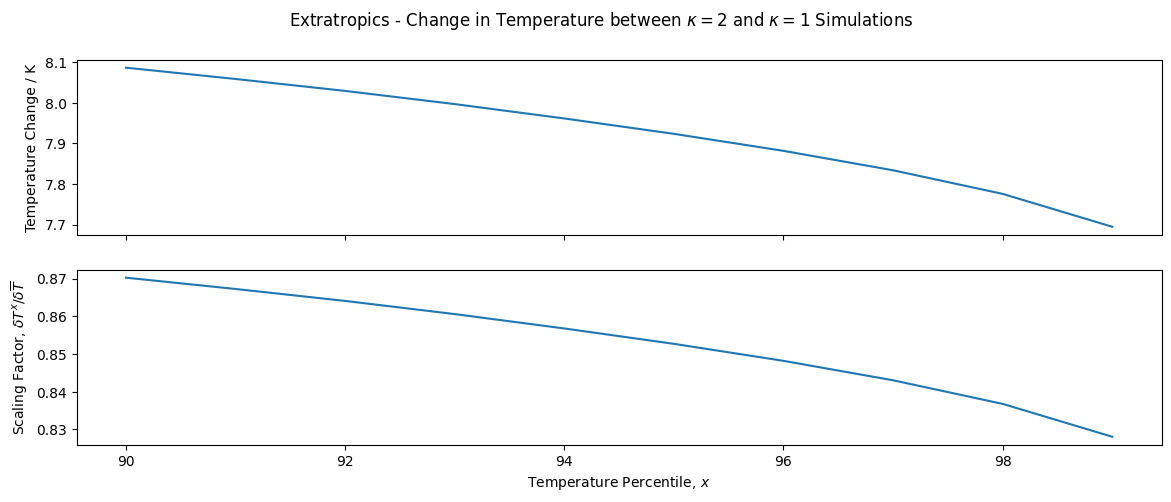

In [564]:
# In second plot here, normalise by change in the summer mean temperature
temp_diff_quant = temp_all_quant[1]-temp_all_quant[0]
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant)
ax[0].set_ylabel('Temperature Change / K')
ax[1].plot(quantiles_all, temp_diff_quant/(temp_summer_av[1] - temp_summer_av[0]))
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Theory for Temperature Change, $\delta T_x$ of days exceeding percentile $x$
This is trying to get a theory for the change in temperature of a given percentile day in a manor analagous to byrne 2021.

In [425]:
p_surface = float(ds_summer[0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def moving_average(x, w):
    # Takes average over w consecutive values in x
    return np.convolve(x, np.ones(w), 'valid') / w

def sphum_surface_sat(temp):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), p_surface)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

# Get the average temperature between experiments for computing some of the parameters below
# Initially thought should use the mid point for this but actually in taylor series, you evaluate at lowest (k=1) value.,
# temp_mean_mid = np.mean(temp_summer_av)             # mean refers to summer mean
temp_mean_mid = temp_summer_av[0]
# temp_quant_mid = np.mean(temp_all_quant, axis=0)
temp_quant_mid = temp_all_quant[0]

In [426]:
# Compute constants required for theory
alpha_quant = clausius_clapeyron_factor(temp_quant_mid)
alpha_mean = clausius_clapeyron_factor(temp_mean_mid)
q_quant = np.asarray([np.asarray([ds_quant[i][j].sphum[-1] for j in range(n_quantiles)]) for i in range(n_exp)])
# q_quant_mid = np.mean(q_quant, axis=0)
q_quant_mid = q_quant[0]
q_mean = np.asarray([ds_summer[i].sphum[-1] for i in range(n_exp)])
# q_mean_mid = np.mean(q_mean)
q_mean_mid = q_mean[0]
rh_quant = rh_from_sphum(q_quant,temp_all_quant,p_surface)/100
rh_mean = rh_from_sphum(q_mean,temp_summer_av,p_surface)/100

q_sat_quant = sphum_surface_sat(temp_quant_mid)
q_sat_mean = sphum_surface_sat(temp_mean_mid)

epsilon_constant = (L_v * alpha_quant * q_sat_quant) / (c_p + L_v * alpha_quant * q_quant_mid)
delta_rh_quant = rh_quant[1] - rh_quant[0]
# prefactor = 1/(1+epsilon_constant * delta_rh_quant)      # prefactor is 1 if RH is constant between k=2 and k=1 experiments
prefactor = 1 # this is when the non linear dT_xdr_x term is not included in expansion of dq*_x

gamma_t = (c_p + L_v * alpha_mean * q_mean_mid) / (c_p + L_v * alpha_quant * q_quant_mid)
# not sure about this, seems to be factor of 100 out - maybe due to definition of relative humidity
gamma_r = (L_v * q_sat_mean) / (c_p + L_v * alpha_quant * q_quant_mid)
gamma_r_quant = -epsilon_constant/alpha_quant
gamma_mse = 1 / (c_p + L_v * alpha_quant * q_quant_mid)

gamma_nl = alpha_mean * gamma_r  # non linear term to accompany delta_rh_mean and delta_t_mean - probably ignore as small

delta_t_mean = temp_summer_av[1] - temp_summer_av[0]
delta_rh_mean = rh_mean[1] - rh_mean[0]

In [427]:
# Compute the delta h* term based on the saturation MSE in the free troposphere
pressure_ft = 700
def mse_ft(dataset):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    ds_use = dataset.sel(pfull=pressure_ft, method='nearest')
    pressure_ft_actual = ds_use.pfull * 100     # This is the pressure level closest to pressure_ft
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), pressure_ft_actual)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)

mse_ft_sat_quant = np.zeros((n_exp, n_quantiles))
mse_ft_sat_summer = np.zeros(n_exp)
for i in range(n_exp):
    mse_ft_sat_summer[i] = mse_ft(ds_summer[i])
    for j in range(n_quantiles):
        mse_ft_sat_quant[i, j] = mse_ft(ds_quant[i][j])

mse_sat_diff = mse_ft_sat_quant - mse_ft_sat_summer.reshape(-1, 1)
delta_mse_sat_diff = (mse_sat_diff[1] - mse_sat_diff[0]) * 1000   # *1000 so in units of J/kg

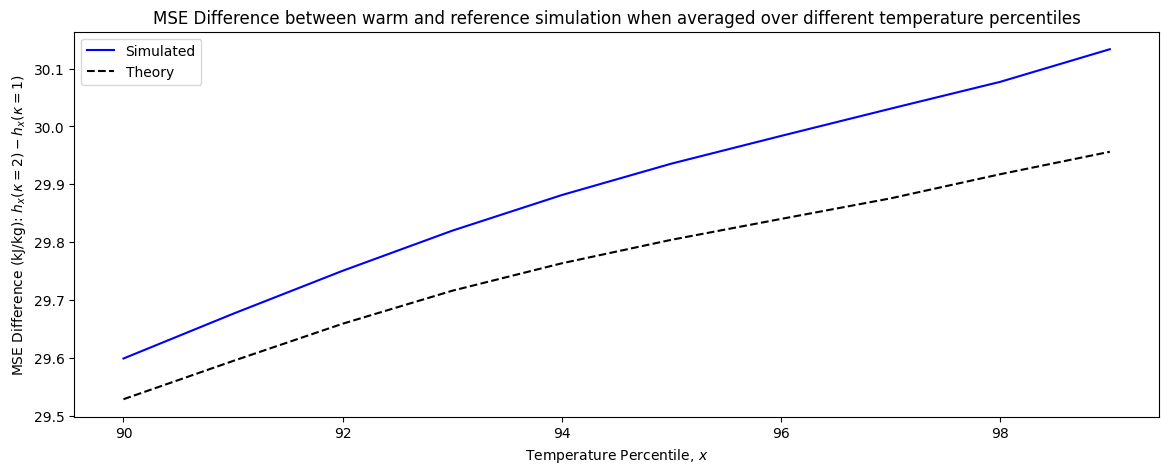

In [550]:
## Compare predicted MSE difference to that from the theory
mse_quant_diff = (c_p * temp_diff_quant + L_v * (q_quant[1]-q_quant[0])) / 1000
mse_quant_diff_sim = (c_p * (temp_summer_av[1]-temp_summer_av[0]) + L_v * (q_mean[1]-q_mean[0]))/1000 + mse_sat_diff[1]-mse_sat_diff[0]

fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True)
ax.plot(quantiles_all, mse_quant_diff, color='blue', label='Simulated')
ax.plot(quantiles_all, mse_quant_diff_sim, color='k', linestyle='--', label='Theory')
ax.set_xlabel('Temperature Percentile, $x$')
ax.set_ylabel(f'MSE Difference (kJ/kg): $h_x(\kappa={tau_lw_warm})-h_x(\kappa={tau_lw_ref})$')
ax.set_title('MSE Difference between warm and reference simulation when averaged over different temperature percentiles')
ax.legend();

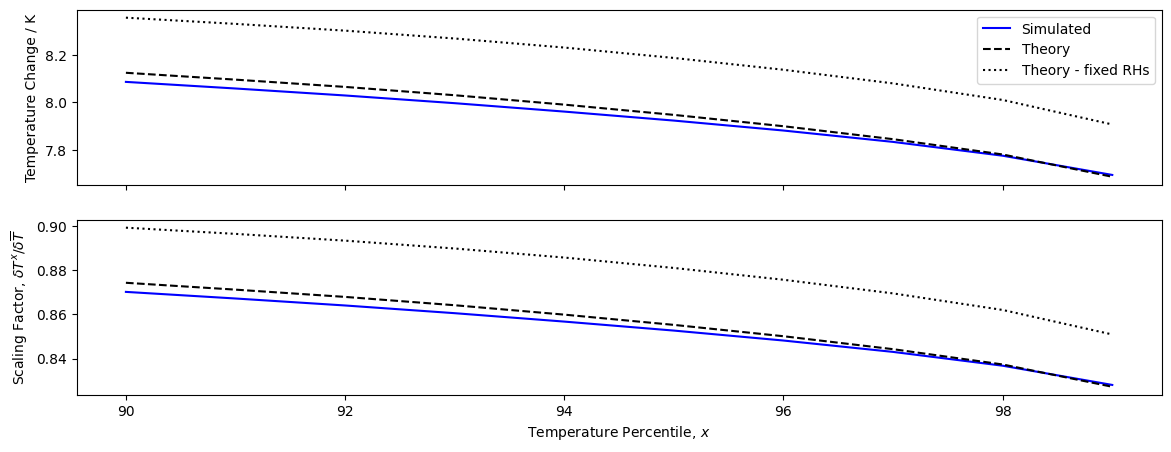

In [704]:
# Compared predicted temperature difference - Figure 2 of byrne 2021
temp_diff_theory = prefactor * (gamma_t*delta_t_mean + gamma_r * delta_rh_mean + gamma_r_quant * delta_rh_quant +
                                gamma_mse * delta_mse_sat_diff)
temp_diff_theory_const_rh = gamma_t*delta_t_mean + gamma_mse * delta_mse_sat_diff
# Consider adding non-linear term to theory temperature
# temp_diff_theory = temp_diff_theory + prefactor * gamma_nl * delta_rh_mean * delta_t_mean
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant, color='blue', label='Simulated')
ax[0].plot(quantiles_all, temp_diff_theory, color='k', linestyle='--', label='Theory')
ax[0].plot(quantiles_all, temp_diff_theory_const_rh, color='k', linestyle=':', label='Theory - fixed RHs')
ax[1].plot(quantiles_all, temp_diff_quant/(temp_summer_av[1] - temp_summer_av[0]), color='blue', label='Simulated')
ax[1].plot(quantiles_all, temp_diff_theory/(temp_summer_av[1] - temp_summer_av[0]), color='k', linestyle='--', label='Theory')
ax[1].plot(quantiles_all, temp_diff_theory_const_rh / (temp_summer_av[1] - temp_summer_av[0]),
           color='k', linestyle=':', label='Theory - fixed RHs')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();

## Breakdown the contributions to the theoretical temperature change
The idea here is to breakdown the temperature contributions to see what is the dominant term in the theory, explaining why the temperature change decreases as the percentile increases.

It is basically replicating Figure 4 of Byrne 2021.

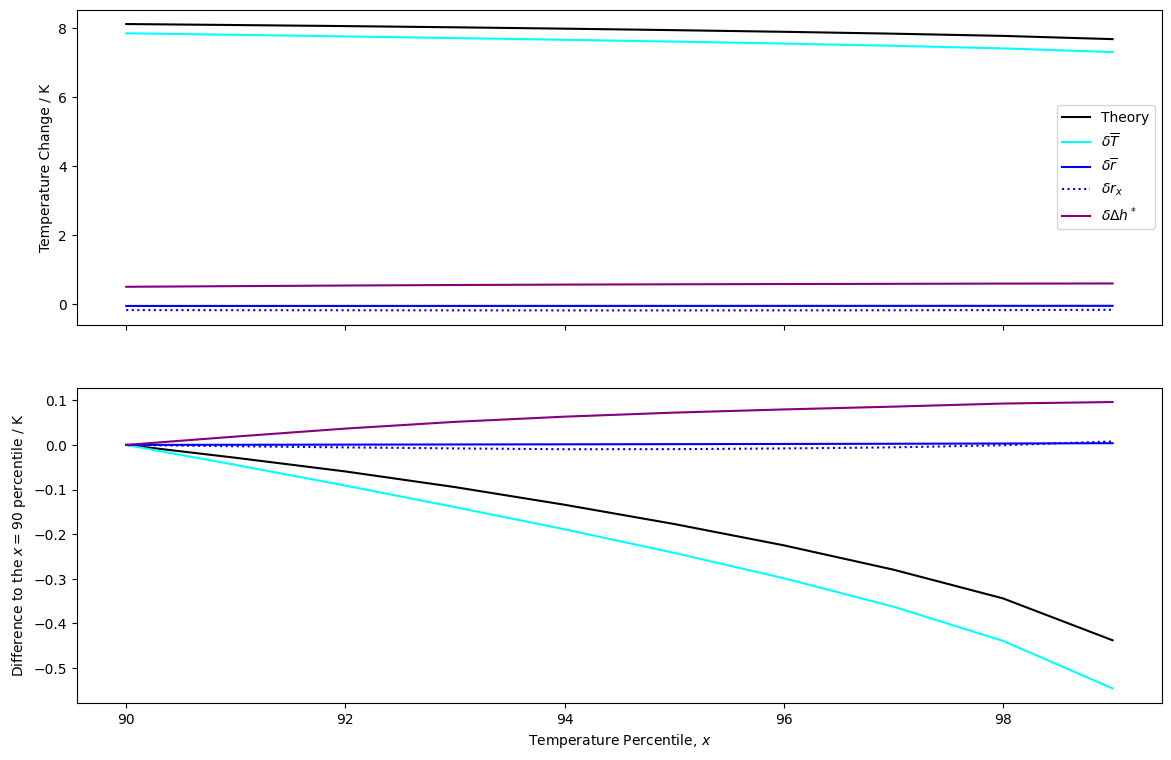

In [825]:
temp_diff_terms = [gamma_t * delta_t_mean, gamma_r * delta_rh_mean, gamma_r_quant * delta_rh_quant, gamma_mse * delta_mse_sat_diff]
temp_diff_terms = [prefactor * term for term in temp_diff_terms]
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
ax[0].plot(quantiles_all, temp_diff_theory, color='k', label='Theory')
ax[0].plot(quantiles_all, temp_diff_terms[0], color='cyan', label='$\delta \overline{T}$')
ax[0].plot(quantiles_all, temp_diff_terms[1], color='blue', label='$\delta \overline{r}$')
ax[0].plot(quantiles_all, temp_diff_terms[2], color='blue', label='$\delta r_x$', linestyle=':')
ax[0].plot(quantiles_all, temp_diff_terms[3], color='purple', label='$\delta \Delta h^*$')

ax[1].plot(quantiles_all, temp_diff_theory - temp_diff_theory[0], color='k', label='Theory')
ax[1].plot(quantiles_all, temp_diff_terms[0]-temp_diff_terms[0][0], color='cyan', label='$\delta \overline{T}$')
ax[1].plot(quantiles_all, temp_diff_terms[1]-temp_diff_terms[1][0], color='blue', label='$\delta \overline{r}$')
ax[1].plot(quantiles_all, temp_diff_terms[2]-temp_diff_terms[2][0], color='blue', label='$\delta r_x$', linestyle=':')
ax[1].plot(quantiles_all, temp_diff_terms[3]-temp_diff_terms[3][0], color='purple', label='$\delta \Delta h^*$')

ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile / K')
ax[0].legend();

So from the above plots, the fact that the mean temperature contribution $\delta \overline{T}$ is the dominant effect. The relative humidities don't really do anything and the moist static energy increases as temperature percentile increases, but this increase is dominated by the $\delta \overline{T}$ effect.

To investigate this further, I plot how the sensitivities ($\gamma$ factors) vary with percentile, in plots analagous to Extended data Figure 4 of Byrne 2021:

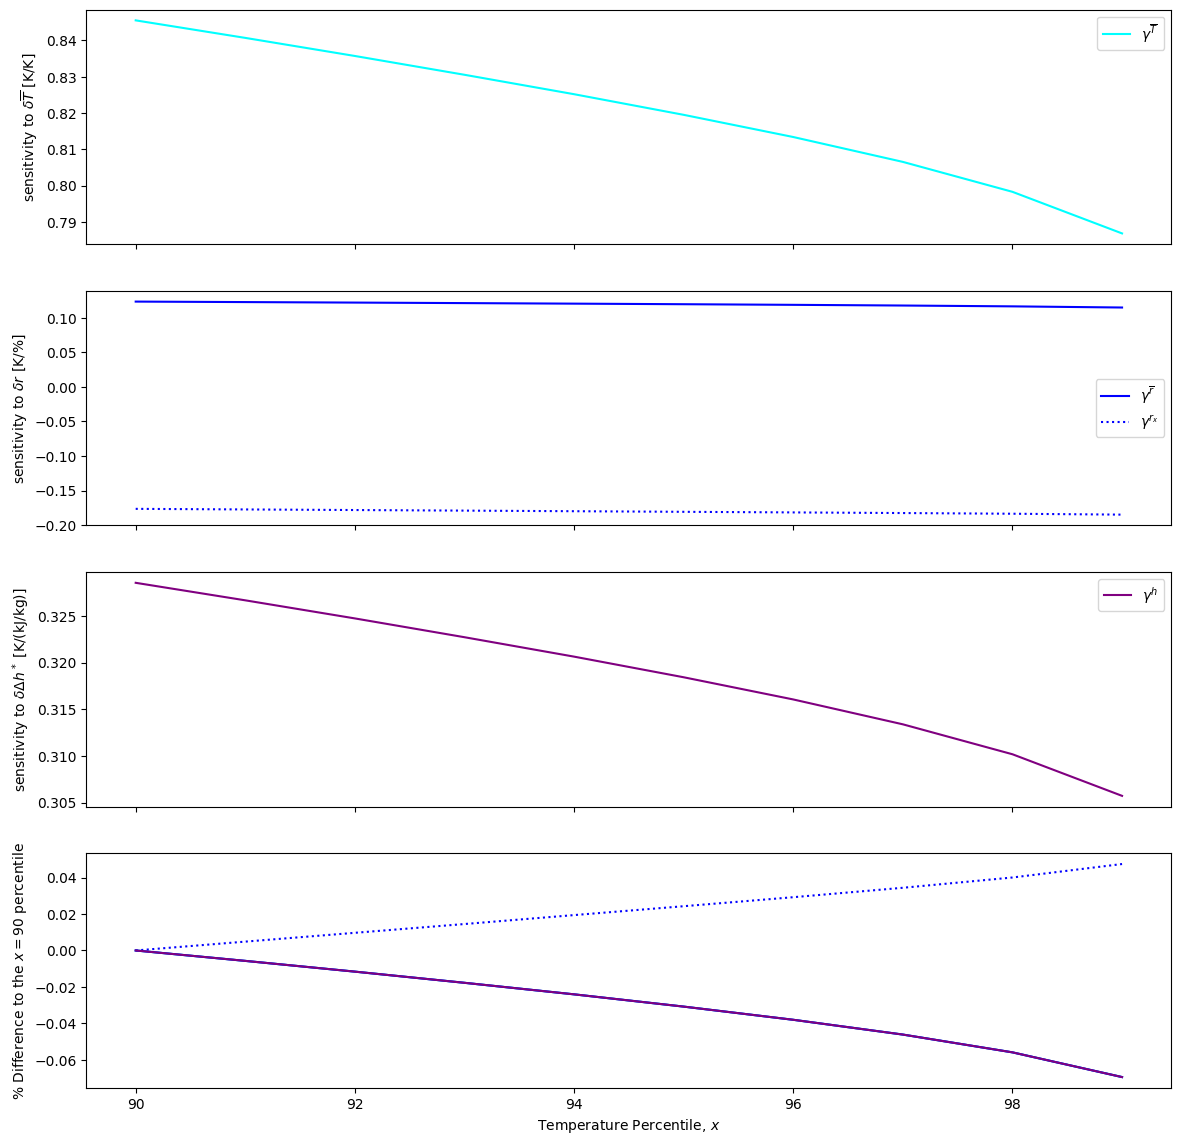

In [824]:
fig, ax = plt.subplots(4,1, figsize=(14, 14), sharex=True)
ax[0].plot(quantiles_all, gamma_t, color='cyan', label='$\gamma^{\overline{T}}$')
ax[0].set_ylabel('sensitivity to $\delta \overline{T}$ [K/K]')
ax[0].legend()

ax[1].plot(quantiles_all, gamma_r/100, color='blue', label='$\gamma^{\overline{r}}$')
ax[1].plot(quantiles_all, gamma_r_quant/100, color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[1].set_ylabel('sensitivity to $\delta r$ [K/%]')
ax[1].legend()

ax[2].plot(quantiles_all, gamma_mse * 1000, color='purple', label='$\gamma^{h}$')
ax[2].set_ylabel('sensitivity to $\delta \Delta h^*$ [K/(kJ/kg)]')
ax[2].legend()

ax[3].plot(quantiles_all, (gamma_t-gamma_t[0])/gamma_t[0], color='cyan', label='$\gamma^{\overline{T}}$')
ax[3].plot(quantiles_all, (gamma_r-gamma_r[0])/gamma_r[0], color='blue', label='$\gamma^{\overline{r}}$')
ax[3].plot(quantiles_all, (gamma_r_quant-gamma_r_quant[0])/gamma_r_quant[0], color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[3].plot(quantiles_all, (gamma_mse-gamma_mse[0])/gamma_mse[0], color='purple', label='$\gamma^{h}$')
ax[3].set_ylabel(f'% Difference to the $x={quantiles_all[0]}$ percentile')
ax[3].set_xlabel('Temperature Percentile, $x$');

From this, wee see that the sensitivity to the mean summer temperature (first plot) shows the opposite behaviour here to that in byrne 2021, where the sensitivity increases with percentile.

The sensitivity to relative humidity on hot days (orange) here behaves approximately the same way as sensitivity to land relative humidity in byrne 2021. But here, the sensitivity to relative humidity on the average summer day (blue line) decreases whereas the analagous parameter in byrne 2021 increases with $x$.

We also see that the sensitivity to the moist static energy difference decreases with $x$.

## Decomposition of $\delta \Delta h^*$ term
This term depends on the average summer free troposphere temperature, the temperature difference and the geopotential height difference.


In [692]:
# Get free troposphere temperature and geopotential height
temp_ft_quant = np.zeros((n_exp, n_quantiles))
temp_ft_summer = np.zeros(n_exp)
z_quant = np.zeros((n_exp, n_quantiles))
z_ft_quant = np.zeros((n_exp, n_quantiles))
z_summer = np.zeros(n_exp)
z_ft_summer = np.zeros(n_exp)
for i in range(n_exp):
    z_summer[i] = ds_summer[i].height[-1]
    ds_use = ds_summer[i].sel(pfull=pressure_ft, method='nearest')
    temp_ft_summer[i] = float(ds_use.temp)
    z_ft_summer[i] = float(ds_use.height)
    for j in range(n_quantiles):
        z_quant[i, j] = ds_quant[i][j].height[-1]
        ds_use = ds_quant[i][j].sel(pfull=pressure_ft, method='nearest')
        temp_ft_quant[i, j] = float(ds_use.temp)
        z_ft_quant[i, j] = float(ds_use.height)
pressure_ft_actual = float(ds_use.pfull * 100)     # This is the pressure level closest to pressure_ft - same for all ds
temp_ft_diff = temp_ft_quant - temp_ft_summer.reshape(-1, 1)
z_ft_diff = z_ft_quant - z_ft_summer.reshape(-1, 1)
delta_temp_ft_mean = temp_ft_summer[1] - temp_ft_summer[0]
delta_temp_ft_quant = temp_ft_quant[1] - temp_ft_quant[0]
delta_temp_ft_diff = temp_ft_diff[1] - temp_ft_diff[0]
delta_z_ft_diff = z_ft_diff[1] - z_ft_diff[0]

In [493]:
# Decompose contributions to changes in /Delta h^*
def sphum_ft_sat(temp):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure_ft_actual)
    q_sat = w_sat / (1+w_sat)
    return q_sat

temp_ft_mean_mid = np.average(temp_ft_summer)
temp_ft_quant_mid = np.mean(temp_ft_quant, axis=0)
temp_ft_mean_mid = temp_ft_summer[0]
temp_ft_quant_mid = temp_ft_quant[0]
alpha_ft_mean = clausius_clapeyron_factor(temp_ft_mean_mid)
q_sat_ft_mean = sphum_ft_sat(temp_ft_mean_mid)
alpha_ft_quant = clausius_clapeyron_factor(temp_ft_quant_mid)
q_sat_ft_quant = sphum_ft_sat(temp_ft_quant_mid)

gamma_temp_ft_quant = c_p + L_v * alpha_ft_quant * q_sat_ft_quant
gamma_temp_ft_mean = -c_p - L_v * alpha_ft_mean * q_sat_ft_mean
gamma_z = g

delta_mse_sat_diff_sim = gamma_temp_ft_quant * delta_temp_ft_quant + gamma_temp_ft_mean * delta_temp_ft_mean + gamma_z * delta_z_ft_diff


In [498]:
# Compute coefficients in the taylor series version of the theory so in terms of temp_diff between mean and warmest days
# Underestimates difference
temp_ft_diff = temp_ft_quant - temp_ft_summer.reshape(-1,1)
temp_ft_diff_mid = temp_ft_diff[0]
gamma_temp_ft_mean2 = L_v * alpha_ft_mean * q_sat_ft_mean * \
                      (alpha_ft_mean * temp_ft_mean_mid - 2) * temp_ft_diff_mid / temp_ft_mean_mid
gamma_temp_ft_diff2 = c_p + L_v * alpha_ft_mean * q_sat_ft_mean
# If computed using the T^2 term in the q* expansion - overestimates
gamma_temp_ft_mean3 = gamma_temp_ft_mean2 + L_v * alpha_ft_mean * q_sat_ft_mean * (
    (alpha_ft_mean**2 * temp_ft_mean_mid**2 - 3 * alpha_ft_mean * temp_ft_mean_mid + 6)*0.5*temp_ft_diff_mid**2/temp_ft_mean_mid**2)
gamma_temp_ft_diff3 = gamma_temp_ft_diff2 + \
                      L_v * alpha_ft_mean * q_sat_ft_mean * (alpha_ft_mean * temp_ft_mean_mid - 2) * temp_ft_diff_mid/temp_ft_mean_mid
# gamma_ft_nl = L_v * alpha_ft_mean * q_sat_ft_mean * (
#         (alpha_ft_mean * temp_ft_mean_mid - 2) / temp_ft_mean_mid +
#         (alpha_ft_mean**2 * temp_ft_mean_mid**2 - 3 * alpha_ft_mean * temp_ft_mean_mid + 6)*temp_ft_diff_mid/temp_ft_mean_mid**2)
delta_mse_sat_diff_sim2 = gamma_temp_ft_mean2*delta_temp_ft_mean + gamma_temp_ft_diff2 * delta_temp_ft_diff + gamma_z * delta_z_ft_diff

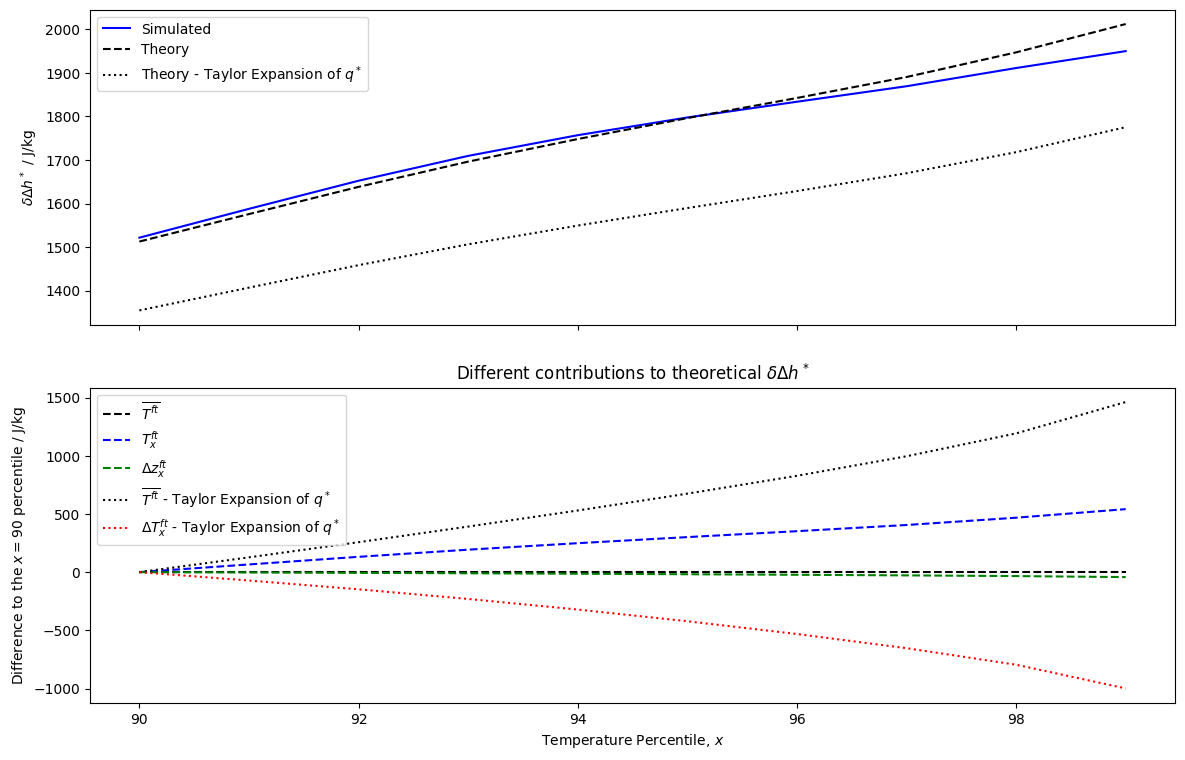

In [821]:
# Plot simulated vs theory delta h*, and then the contributions towards it
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
ax[0].plot(quantiles_all, delta_mse_sat_diff, color='blue', label='Simulated')
ax[0].plot(quantiles_all, delta_mse_sat_diff_sim, color='k', linestyle='--', label='Theory')
ax[0].plot(quantiles_all, delta_mse_sat_diff_sim2, color='k', linestyle=':', label='Theory - Taylor Expansion of $q^*$')
ax[1].plot(quantiles_all, quantiles_all * 0, linestyle='--', label='$\overline{T^{ft}}}$', color='k')
ax[1].plot(quantiles_all, gamma_temp_ft_quant * delta_temp_ft_quant - (gamma_temp_ft_quant * delta_temp_ft_quant)[0],
           linestyle='--', color='blue', label='$T^{ft}_x$')
ax[1].plot(quantiles_all, gamma_z * delta_z_ft_diff - (gamma_z * delta_z_ft_diff)[0],
           linestyle='--', color='green', label='$\Delta z^{ft}_x$')
ax[1].plot(quantiles_all, gamma_temp_ft_mean2 * delta_temp_ft_mean - (gamma_temp_ft_mean2 * delta_temp_ft_mean)[0],
           linestyle=':', color='k', label='$\overline{T^{ft}}}$ - Taylor Expansion of $q^*$')
ax[1].plot(quantiles_all, gamma_temp_ft_diff2 * delta_temp_ft_diff - (gamma_temp_ft_diff2 * delta_temp_ft_diff)[0],
           linestyle=':', color='red', label='$\Delta T^{ft}_x$ - Taylor Expansion of $q^*$')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$\delta\Delta h^*$ / J/kg')
ax[1].set_title('Different contributions to theoretical $\delta\Delta h^*$')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile / J/kg')
ax[1].set_xlabel('Temperature Percentile, $x$');

From this, it seems that the change in geopotential height of the free troposphere has very little effect and the major effect is because the temperature of the free troposphere increases as we move to higher percentiles (blue line).

From the taylor expansion lines, we see that the difference in free troposphere temperature and the mean temperature has a lesser effect as we move to high percentiles $x$. But this overwhealmed by the increasing effect that the increased temperature of the average summer day (black dotted line) has.

This is because the sensitivity to the mean summer temperature (`gamma_temp_ft_mean2`) increases as $x$ increases. I need to add another assumption to get a complete theory.

But $\delta \Delta h_x$ is clearly dependent on $\delta T_x$ and $\delta \overline{T}$ so I think this is somewhat a circular argument.

I think the systematic offset of the taylor expansion theory from the simulated value is because the temperature differences between the $x$ percentile and mean summer day are not small so you should go to higher order in the expansion.

## Theory 4: assuming $T_{x,ft} = \overline{T}_{ft} + \Delta T_{x, ft}$
Assume $\Delta T_{x, ft}$ is small so can taylor expand. Also, can relate $\overline{T}_{ft}$ to the surface temperature, $\overline{T}$, and relative humidity, $\overline{r}$ through assumption of convective equilibrium: $\overline{h} = \overline{h^*_{ft}}$. The logic behind this, is that in the tropics, the free troposphere temperature on the hot and mean day are the same so $\Delta T_{x, ft} = 0$ so can see the difference to the tropics more easily.

This then changes $\gamma^{\overline{T}}$ because it now includes a contribution that was in the $\delta \Delta h^*_x$ term.

In the plot below, it is clear that this theory overestimates the temperature change. This is probably because the assumption that $\Delta T_{x, ft}$ is small is not correct so a greater expansion in the taylor series of $q^*(T_{x,ft})$ was probably needed.

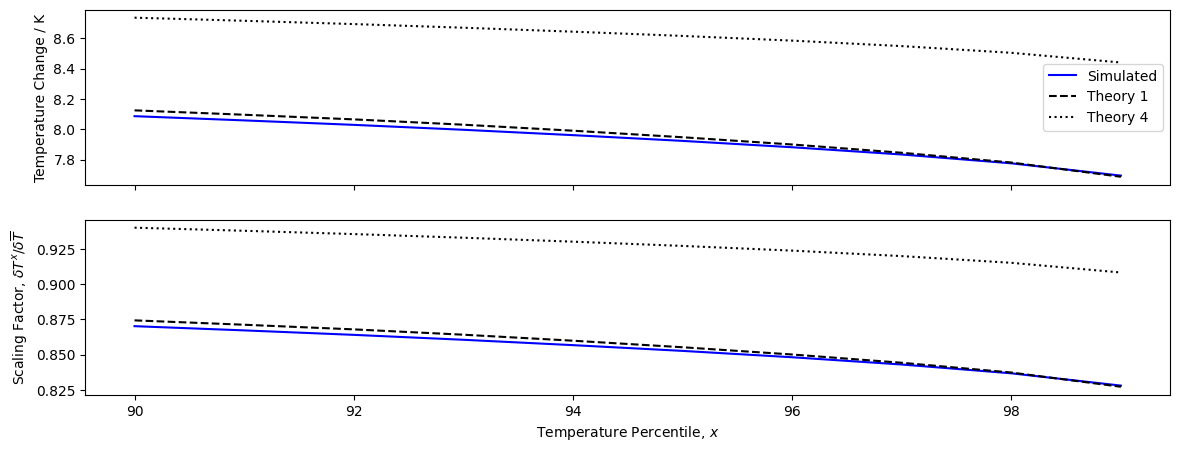

In [789]:
# Theory splitting the contribution from delta h* into temperature and geopotential terms

denom4 = c_p + L_v * q_quant_mid * alpha_quant
beta = (L_v * temp_ft_diff_mid * alpha_ft_mean * q_sat_ft_mean * (alpha_ft_mean - 2/temp_ft_mean_mid)) / \
       (c_p + L_v * alpha_ft_mean * q_sat_ft_mean)
gamma_t4 = ((c_p + L_v * alpha_mean * q_mean_mid) * (1+beta))/denom4
gamma_r4 = L_v * q_sat_mean * (1+beta) / denom4
gamma_r_quant4 = -L_v * q_quant_mid / denom4
gamma_temp_ft_diff4 = L_v * q_sat_ft_mean * alpha_ft_mean / denom4
gamma_z_quant4 = g / denom4
gamma_z4 = -g * (1+beta) / denom4

delta_z_ft_quant = z_ft_quant[1] - z_ft_quant[0]
delta_z_ft_mean = z_ft_summer[1] - z_ft_summer[0]

temp_diff_theory4 = gamma_t4*delta_t_mean + gamma_r4 * delta_rh_mean + gamma_r_quant4 * delta_rh_quant + \
                    gamma_temp_ft_diff4 * delta_temp_ft_diff + gamma_z_quant4 * delta_z_ft_quant + gamma_z4 * delta_z_ft_mean

fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_diff_quant, color='blue', label='Simulated')
ax[0].plot(quantiles_all, temp_diff_theory, color='k', linestyle='--', label='Theory 1')
ax[0].plot(quantiles_all, temp_diff_theory4, color='k', linestyle=':', label='Theory 4')
ax[1].plot(quantiles_all, temp_diff_quant/(temp_summer_av[1] - temp_summer_av[0]), color='blue', label='Simulated')
ax[1].plot(quantiles_all, temp_diff_theory/(temp_summer_av[1] - temp_summer_av[0]), color='k', linestyle='--', label='Theory')
ax[1].plot(quantiles_all, temp_diff_theory4 / (temp_summer_av[1] - temp_summer_av[0]),
          color='k', linestyle=':', label='Theory - fixed RHs')
ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[0].legend();

## Breakdown the contributions to the theoretical temperature change
The idea here is to breakdown the temperature contributions to see what is the dominant term in the theory, explaining why the temperature change decreases as the percentile increases.

It is basically replicating Figure 4 of Byrne 2021.

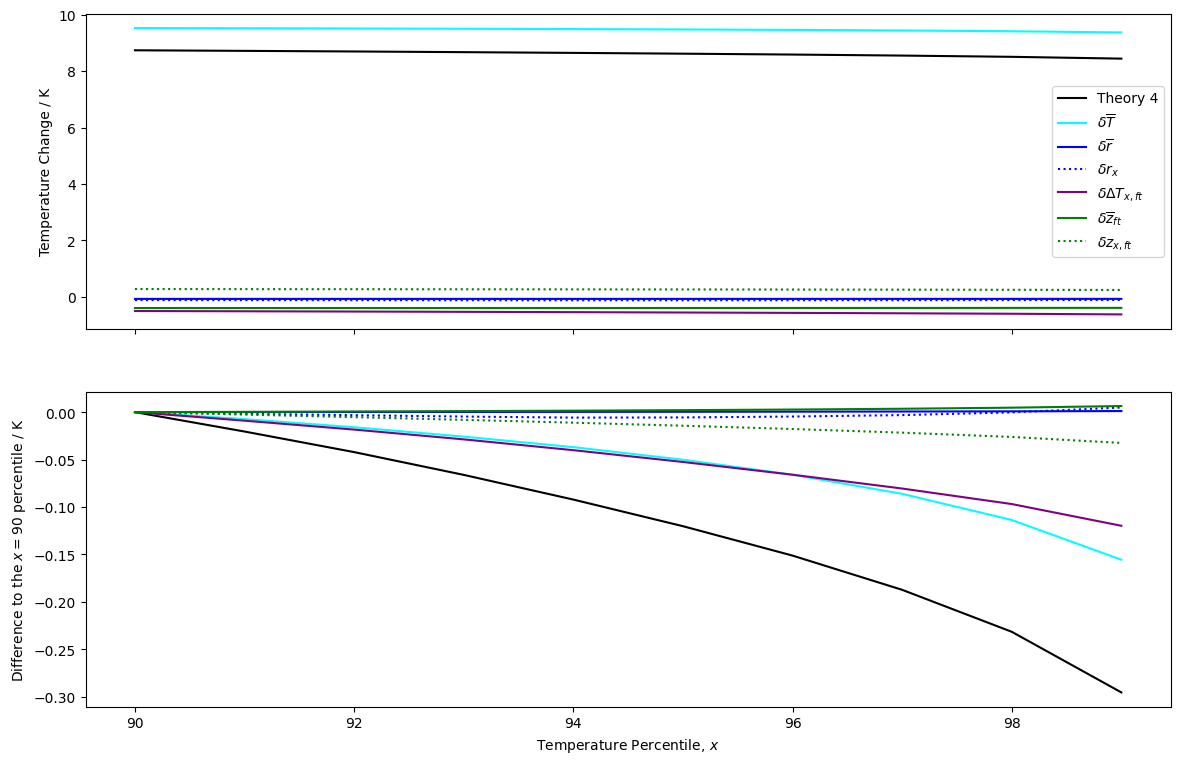

In [820]:
temp_diff_terms4 = [gamma_t4 * delta_t_mean, gamma_r4 * delta_rh_mean, gamma_r_quant4 * delta_rh_quant,
                   gamma_temp_ft_diff4 * delta_temp_ft_diff, gamma_z4 * delta_z_ft_mean, gamma_z_quant4 * delta_z_ft_quant]
fig, ax = plt.subplots(2,1, figsize=(14, 9), sharex=True)
ax[0].plot(quantiles_all, temp_diff_theory4, color='k', label='Theory 4')
ax[0].plot(quantiles_all, temp_diff_terms4[0], color='cyan', label='$\delta \overline{T}$')
ax[0].plot(quantiles_all, temp_diff_terms4[1], color='blue', label='$\delta \overline{r}$')
ax[0].plot(quantiles_all, temp_diff_terms4[2], color='blue', label='$\delta r_x$', linestyle=':')
ax[0].plot(quantiles_all, temp_diff_terms4[3], color='purple', label='$\delta \Delta T_{x,ft}$')
ax[0].plot(quantiles_all, temp_diff_terms4[4], color='green', label='$\delta \overline{z}_{ft}$')
ax[0].plot(quantiles_all, temp_diff_terms4[5], color='green', label='$\delta z_{x,ft}$', linestyle=':')

ax[1].plot(quantiles_all, temp_diff_theory4 - temp_diff_theory4[0], color='k', label='Theory 4')
ax[1].plot(quantiles_all, temp_diff_terms4[0]-temp_diff_terms4[0][0], color='cyan', label='$\delta \overline{T}$')
ax[1].plot(quantiles_all, temp_diff_terms4[1]-temp_diff_terms4[1][0], color='blue', label='$\delta \overline{r}$')
ax[1].plot(quantiles_all, temp_diff_terms4[2]-temp_diff_terms4[2][0], color='blue', label='$\delta r_x$', linestyle=':')
ax[1].plot(quantiles_all, temp_diff_terms4[3]-temp_diff_terms4[3][0], color='purple', label='$\delta \Delta h^*$')
ax[1].plot(quantiles_all, temp_diff_terms4[4]-temp_diff_terms4[4][0], color='green', label='$\delta \overline{z}_{ft}$')
ax[1].plot(quantiles_all, temp_diff_terms4[5]-temp_diff_terms4[5][0], color='green', label='$\delta z_{x,ft}$', linestyle=':')

ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel(f'Difference to the $x={quantiles_all[0]}$ percentile / K')
ax[0].legend();

The plots below show how the sensitivities ($\gamma$ factors) vary with percentile, in plots analagous to Extended data Figure 4 of Byrne 2021:

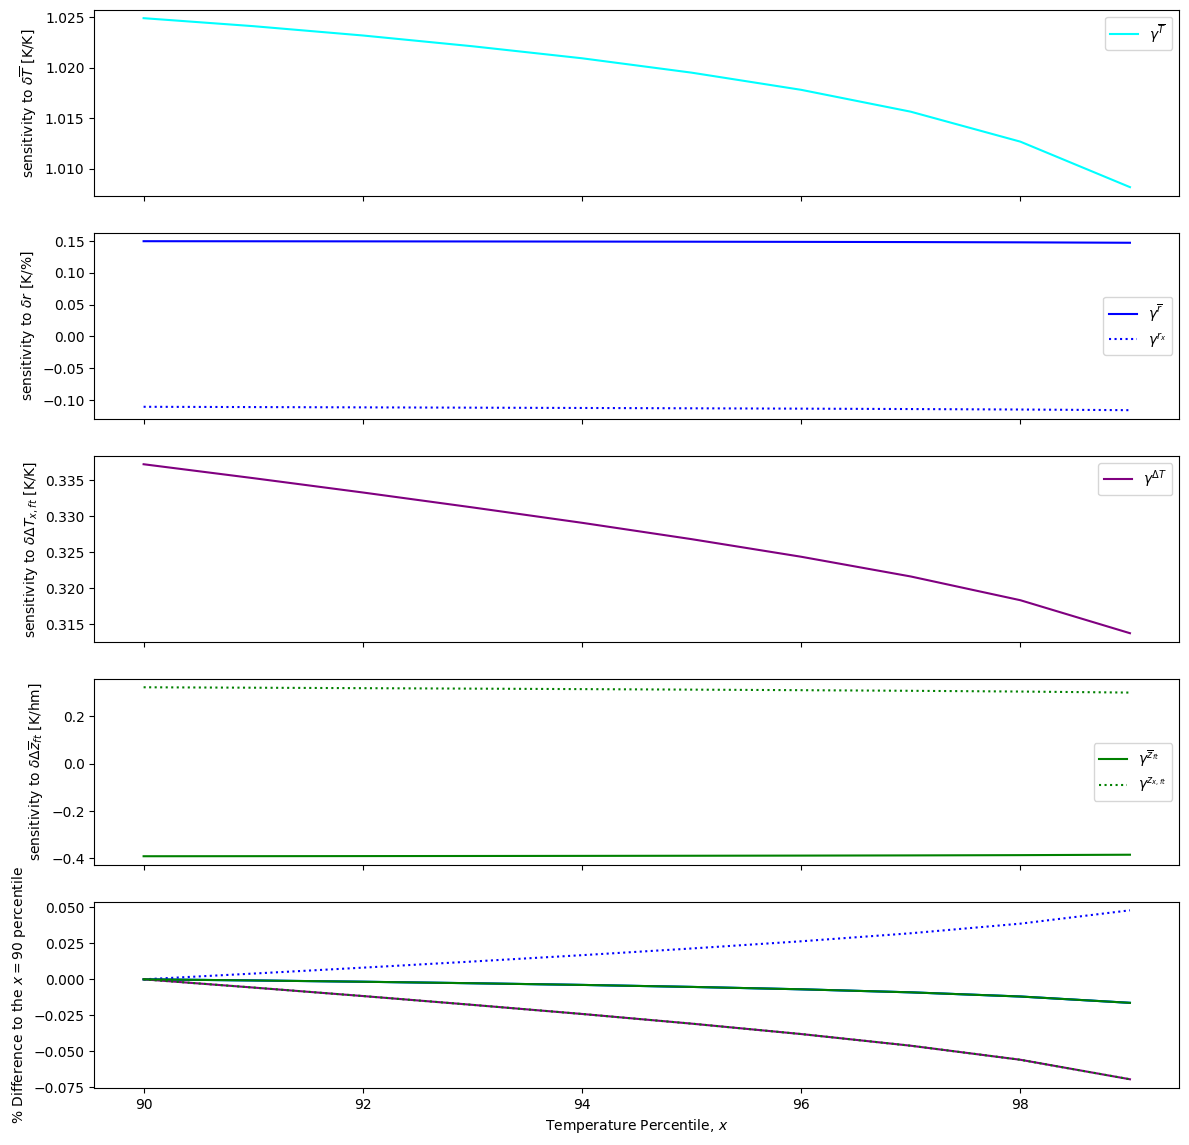

In [819]:
fig, ax = plt.subplots(5,1, figsize=(14, 14), sharex=True)
ax[0].plot(quantiles_all, gamma_t4, color='cyan', label='$\gamma^{\overline{T}}$')
ax[0].set_ylabel('sensitivity to $\delta \overline{T}$ [K/K]')
ax[0].legend()

ax[1].plot(quantiles_all, gamma_r4/100, color='blue', label='$\gamma^{\overline{r}}$')
ax[1].plot(quantiles_all, gamma_r_quant4/100, color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[1].set_ylabel('sensitivity to $\delta r$ [K/%]')
ax[1].legend()

ax[2].plot(quantiles_all, gamma_temp_ft_diff4, color='purple', label='$\gamma^{\Delta T}$')
ax[2].set_ylabel('sensitivity to $\delta \Delta T_{x,ft}$ [K/K]')
ax[2].legend()

ax[3].plot(quantiles_all, gamma_z4*100, color='green', label='$\gamma^{\overline{z}_{ft}}$')
ax[3].plot(quantiles_all, gamma_z_quant4*100, color='green', label='$\gamma^{z_{x, ft}}$', linestyle=':')
ax[3].set_ylabel('sensitivity to $\delta \Delta \overline{z}_{ft}}$ [K/hm]')
ax[3].legend()

ax[4].plot(quantiles_all, (gamma_t4-gamma_t4[0])/gamma_t4[0], color='cyan', label='$\gamma^{\overline{T}}$')
ax[4].plot(quantiles_all, (gamma_r4-gamma_r4[0])/gamma_r4[0], color='blue', label='$\gamma^{\overline{r}}$')
ax[4].plot(quantiles_all, (gamma_r_quant4-gamma_r_quant4[0])/gamma_r_quant4[0], color='blue', label='$\gamma^{r_x}$', linestyle=':')
ax[4].plot(quantiles_all, (gamma_temp_ft_diff4-gamma_temp_ft_diff4[0])/gamma_temp_ft_diff4[0], color='purple',
           label='$\gamma^{\Delta T}$')
ax[4].plot(quantiles_all, (gamma_z4 - gamma_z4[0])/gamma_z4[0], color='green', label='$\gamma^{\overline{z}_{ft}}$')
ax[4].plot(quantiles_all, (gamma_z_quant4 - gamma_z_quant4[0])/gamma_z_quant4[0], color='green', label='$\gamma^{z_{x, ft}}$', linestyle=':')
ax[4].set_ylabel(f'% Difference to the $x={quantiles_all[0]}$ percentile')
ax[4].set_xlabel('Temperature Percentile, $x$');